In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from scipy.io import readsav
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.io.fits as fits
from astropy import units as u
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, LogStretch, LogStretch, PercentileInterval
import sunpy
import sunpy.map
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.sun import constants as const
from sunpy.coordinates import SphericalScreen
import gzip
import requests
import urllib.request
from datetime import datetime
from bs4 import BeautifulSoup
import pfsspy
import pfsspy.tracing as tracing
from sunkit_instruments import suvi
from tqdm import tqdm

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs

# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is imported/stored
data_dir = '/home/mnedal/data'
savedir = '/home/mnedal/repos/dias_work'

In [3]:
def find_links(url='http://www.python.org'):
    """
    Get all the links in a webpage.
    Source: https://stackoverflow.com/questions/20150184/make-a-list-of-all-the-files-on-a-website
    """
    soup = BeautifulSoup(requests.get(url).text)
    hrefs = []
    for a in soup.find_all('a'):
        hrefs.append(a['href'])
    return hrefs


def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 and C3 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects


def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict


def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())


def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs: list of EUV sunpy maps.
        Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio


def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized


def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax


def geo_to_cartesian(latitude, longitude, radius=1):
    """
    Convert geographic coordinates to Cartesian coordinates.
    """
    # Convert degrees to radians
    lat_rad = np.deg2rad(latitude)
    lon_rad = np.deg2rad(longitude)
    
    # Cartesian coordinates
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    
    return x, y, z


def get_forward_map(forward_imagefile, bottom_left=None, top_right=None):
    """
    ========================================================================================
    Function returns a Helioprojective Map from FORWARD outputs.
    Kamen Kozarev, based on code written by Laura Hayes.
    ========================================================================================
    How to create a `~sunpy.map.Map` in Helioprojective Coordinate Frame from FORWARD model.
    In this example we read the data and header information from the FORWARD SAV file and then create 
    a new header with updated WCS information to create a `~sunpy.map.Map` with a HPC coordinate frame. 
    We will make use of the `astropy.coordinates` and `sunpy.coordinates` submodules together with 
    `~sunpy.map.make_fitswcs_header` to create a new header and generate a `~sunpy.map.Map`.
    """
    ##############################################################################
    # We will first begin be reading in the header and data from the SAV file.
    hdul = readsav(forward_imagefile)
    
    #####################################################################################
    # The data in this file is in a datacube structure
    data = np.array(hdul['quantmap'].DATA[0])
    ###############################################################################
    # Lets pull out the observation time and quantity, we will use
    # these to create our new header.
    # Now we need to get the other parameters from the header that will be used
    # to create the new header - here we can get the cdelt1 and cdelt2 which are
    # the spatial scales of the data axes.

    pxrsun = hdul['quantmap'][0][4]
    # obstime = str(hdul['quantmap'][0][5]).split('\'')[1] + 'T12:00:00'
    obstime = str(hdul['quantmap'][0][5]).split('\'')[1]
    quantity = str(hdul['quantmap'][0][6]).split('!')[0].split('\'')[1]
    try:
        units = str(hdul['quantmap'][0][12]).split('\'')[1]
    except:
        units = ''
    rsunasec = 950.
    asecpx = rsunasec * pxrsun
    cdelt1 = asecpx
    cdelt2 = asecpx
    naxis1 = hdul['gridinputs'][0][22]
    naxis2 = hdul['gridinputs'][0][24]
    crpix1 = int(naxis1/2)
    if type(naxis2) == bytes:
        if naxis2.decode('utf-8') == 'NULL':
            crpix2 = ''
        else:
            crpix2 = int(naxis2.decode('utf-8')/2)
    else:
        crpix2 = int(naxis2/2)
    crval1 = 0
    crval2 = 0
    
    ###############################################################################
    # To create a new `~sunpy.map.Map` header we need convert the reference coordinate
    # to Helioprojective. To do this we will first create
    # an `astropy.coordinates.SkyCoord` of the reference coordinate from the header information.
    # We will need the location of the observer (i.e. where the observation was taken).
    reference_coord = SkyCoord(crval1*u.arcsec, crval2*u.arcsec, frame='helioprojective', obstime=obstime)
    ##########################################################################
    
    ##########################################################################
    # Now we can use this information to create a new header using the helper
    # function `~sunpy.map.make_fitswcs_header()`. This will create a MetaDict
    # which we contain all the necessay WCS information to create a `~sunpy.map.Map`.
    new_header = sunpy.map.make_fitswcs_header(data,
                                               reference_coord,
                                               reference_pixel=u.Quantity([crpix1, crpix1]*u.pixel),
                                               scale=u.Quantity([cdelt1, cdelt2]*u.arcsec/u.pix),
                                               rotation_angle=0*u.degree,
                                               observatory='PSIMAS/FORWARD',
                                               instrument=quantity)
    ##########################################################################
    # Lets create a `~sunpy.map.Map`.
    forward_map = sunpy.map.Map(data, new_header)
    ##########################################################################
    ##########################################################################
    # We can now rotate the image so that solar north is pointing up and create
    # a submap in the field of view of interest.
    forward_map_rotate = forward_map.rotate()
    
    if bottom_left is not None:
        bl = SkyCoord(bottom_left[0]*u.arcsec, bottom_left[1]*u.arcsec, frame=forward_map_rotate.coordinate_frame)
    if top_right is not None:
        tr = SkyCoord(top_right[0]*u.arcsec, top_right[1]*u.arcsec, frame=forward_map_rotate.coordinate_frame)
    if bottom_left and top_right:
        forward_submap = forward_map_rotate.submap(bl, top_right=tr)
    else:
        forward_submap = forward_map_rotate
    ##########################################################################
    
    return forward_submap


def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]


def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec
    
    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point   = SkyCoord(center.Tx + line_length * np.cos(angle_rad), 
                           center.Ty + line_length * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line


def draw_circle(ax, mymap, radius_factor, label=True, text_offset=0.75, **kwargs):
    """
    Draws a circle on the SunPy map with a given radius factor and optional label.

    Parameters:
    - ax : Matplotlib axis
    - mymap : SunPy map
    - radius_factor : Factor of the Sun's observed radius (e.g., 1 for Rsun, 2 for 2*Rsun, etc.)
    - label : Whether to add a text label inside the circle (default is True).
    - text_offset : Fraction of the radius to shift the label (default 0.2).
    - **kwargs : Additional Matplotlib styling arguments (color, linestyle, linewidth, alpha, etc.)
    """
    # Compute the circle radius
    circle_radius = radius_factor * mymap.rsun_obs  # Multiply factor by Sun radius

    # Generate circle coordinates in arcsec
    theta = np.linspace(0, 2 * np.pi, 300)  # Angle array
    x_circle = circle_radius * np.cos(theta)
    y_circle = circle_radius * np.sin(theta)

    # Convert world coordinates to pixels
    circle_coords = mymap.world_to_pixel(SkyCoord(x_circle, y_circle, frame=mymap.coordinate_frame))

    # Plot the circle
    ax.plot(circle_coords.x, circle_coords.y, **kwargs)

    # Add label inside the circle
    if label:
        text_x = circle_radius * text_offset  # Offset the text a bit from the center
        text_y = circle_radius * text_offset
        text_coord = mymap.world_to_pixel(SkyCoord(text_x, text_y, frame=mymap.coordinate_frame))
        
        ax.text(text_coord.x.value, text_coord.y.value, f'r={radius_factor}', color=kwargs.get('color', 'w'), fontsize=10, ha='center', va='center')

## PFSS Plot

In [4]:
YEAR = '2024'
MONTH = '05'
DAY = '14'
HOUR = '17'
MINUTE = '40'

# construct the datetime object 
mydatetime = datetime(int(YEAR), int(MONTH), int(DAY), int(HOUR), int(MINUTE))

# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
print(cr)

# set the field of view of LOFAR observations 
FOV = 3750

mydatetime       = '2024-05-14T17:40'
YEAR, MONTH, DAY = mydatetime.split('T')[0].split('-')
HOUR, MINUTE     = mydatetime.split('T')[1].split(':')
print(YEAR, MONTH, DAY, HOUR, MINUTE)

# show the links of the GONG fileS
gong_url = 'https://gong2.nso.edu/oQR/zqs/%s%s/mrzqs%s%s%s/' %(YEAR, MONTH, YEAR[-2:], MONTH, DAY)
list_gong_links = find_links(url=gong_url)

# show what you've found
for i, link in enumerate(list_gong_links):
    print(i, link)

2284
2024 05 14 17 40
0 ?C=N;O=D
1 ?C=M;O=A
2 ?C=S;O=A
3 ?C=D;O=A
4 /oQR/zqs/202405/
5 mrzqs240514t0004c2284_201.fits.gz
6 mrzqs240514t0104c2284_200.fits.gz
7 mrzqs240514t0114c2284_200.fits.gz
8 mrzqs240514t0244c2284_199.fits.gz
9 mrzqs240514t0454c2284_198.fits.gz
10 mrzqs240514t0604c2284_197.fits.gz
11 mrzqs240514t0704c2284_197.fits.gz
12 mrzqs240514t0814c2284_196.fits.gz
13 mrzqs240514t0914c2284_196.fits.gz
14 mrzqs240514t1004c2284_195.fits.gz
15 mrzqs240514t1114c2284_194.fits.gz
16 mrzqs240514t1204c2284_194.fits.gz
17 mrzqs240514t1304c2284_193.fits.gz
18 mrzqs240514t1414c2284_193.fits.gz
19 mrzqs240514t1514c2284_192.fits.gz
20 mrzqs240514t1614c2284_192.fits.gz
21 mrzqs240514t1714c2284_191.fits.gz
22 mrzqs240514t1814c2284_191.fits.gz
23 mrzqs240514t1904c2284_190.fits.gz
24 mrzqs240514t2004c2284_190.fits.gz
25 mrzqs240514t2104c2284_189.fits.gz
26 mrzqs240514t2204c2284_189.fits.gz
27 mrzqs240514t2354c2284_187.fits.gz


In [5]:
lasco_c2_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C2')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

In [6]:
# remove redundant images
clean_maps_c2 = remove_redundant_maps(lasco_c2_map_objects)

print(f'Before:\nLASCO C2: {len(lasco_c2_map_objects)} images\n')
print(f'After:\nLASCO C2: {len(clean_maps_c2)} images')

Before:
LASCO C2: 150 images

After:
LASCO C2: 13 images


In [7]:
# make run-diff maps
m_seq_runratio_c2 = apply_runratio(clean_maps_c2)

In [8]:
gong_file_index = 22
gong_filename = list_gong_links[gong_file_index]

print(data_dir + gong_filename)

/home/mnedal/datamrzqs240514t1814c2284_191.fits.gz


In [9]:
if not os.path.exists(data_dir + gong_filename[:-3]) and not os.path.exists(data_dir + gong_filename):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=data_dir+gong_filename)

if not os.path.exists(data_dir + gong_filename[:-3]):
    with gzip.open(data_dir + gong_filename, 'rb') as f:
        with open(data_dir + gong_filename[:-3], 'wb') as g:
            g.write(f.read())

In [10]:
gong_map = Map(data_dir + gong_filename[:-3])

if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

nrho     = 50  # number of rho grid points
rss      = 7   # source surface radius
pfss_in  = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

num_footpoints = 20
lat = np.linspace(-0.4*np.pi, 0.5*np.pi, num_footpoints, endpoint=False)
lon = np.linspace(-0.5*np.pi, 1.5*np.pi, num_footpoints+10, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad
r = 1.15*const.radius

# Make a 2D grid from these 1D points 
seeds  = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

2025-04-01 18:32:44 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


## FORWARD Plot

In [11]:
# load files
file_paths = sorted(glob.glob(f'{data_dir}/FORWARD/*.sav'))
print(*file_paths, sep='\n')

/home/mnedal/data/FORWARD/AIA_20240514_1710_193_512_rfilter.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BETA_2460559.9840394disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BMAG_2460559.9356944disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_DENS_2460559.9343750disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_PTOT_2460559.9832407disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_TEMP_2460559.9822801disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VPH_2460593.4820486disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VR_2460593.4744676disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VTH_2460593.4788194disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VX_2460593.5005556disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VY_2460593.5060301disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VZ_2460593.5081481disk.sav


In [12]:
for file in file_paths:
    if 'BMAG' in file:
        bmag = get_forward_map(file)
    elif 'DENS' in file:
        dens = get_forward_map(file)

In [13]:
# Calculate the Alfven speed map
mp = astro_const.m_p.to(u.gram).value
valf_cm_s = bmag.data/np.sqrt(4*np.pi*mp*dens.data)
valf_km_s = valf_cm_s * 1e-5
va = sunpy.map.Map(valf_km_s, dens.meta)

In [14]:
x_range = (-4500, 4500) * u.arcsec
y_range = (-4500, 4500) * u.arcsec

# Convert to SkyCoord for cropping
bottom_left = SkyCoord(x_range[0], y_range[0], frame=va.coordinate_frame)
top_right   = SkyCoord(x_range[1], y_range[1], frame=va.coordinate_frame)

# Crop the map
cropped_map = va.submap(bottom_left=bottom_left, top_right=top_right)


pfss = True
# pfss = False

m_c2_rr = m_seq_runratio_c2[2]

x_range = (-4500, 4500) * u.arcsec
y_range = (-4500, 4500) * u.arcsec

# Convert to SkyCoord for cropping
bottom_left = SkyCoord(x_range[0], y_range[0], frame=m_c2_rr.coordinate_frame)
top_right   = SkyCoord(x_range[1], y_range[1], frame=m_c2_rr.coordinate_frame)

# Crop the map
cropped_c2map = m_c2_rr.submap(bottom_left=bottom_left, top_right=top_right)

2025-04-01 18:32:46 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [15]:
centered_list = generate_centered_list(160, 2, 6)
print(centered_list)

# pick 3 slits
chosen_slits = [ centered_list[0], int(np.median(centered_list)), centered_list[-1] ]
print(chosen_slits)

# rename the slit angle to be PA
PA = [angle - 90 for angle in centered_list]
print(PA)

[148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172]
[148, 160, 172]
[58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82]


In [16]:
def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from solar North, starting at the solar limb.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Convert the observed solar radius to the same unit as the map coordinates
    solar_radius = map_obj.rsun_obs.to(u.deg)  # Convert to degrees if map uses degrees
    
    # Define the center point
    center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Convert solar_radius to the same unit as center.Tx (arcsec or deg)
    solar_radius = solar_radius.to(center.Tx.unit)

    # Compute the start point at the solar limb
    start_point = SkyCoord(center.Tx + solar_radius * np.cos(angle_rad),
                           center.Ty + solar_radius * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)

    # Convert `length` to the same unit
    line_length = length * u.arcsec
    line_length = line_length.to(center.Tx.unit)

    # Define the endpoint at the full length
    end_point = SkyCoord(start_point.Tx + line_length * np.cos(angle_rad), 
                         start_point.Ty + line_length * np.sin(angle_rad),
                         frame=map_obj.coordinate_frame)
    
    return SkyCoord([start_point, end_point])

2025-02-13 16:58:37 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Plotting the field lines: 100%|████████████████████████████████████| 600/600 [00:44<00:00, 13.62it/s]


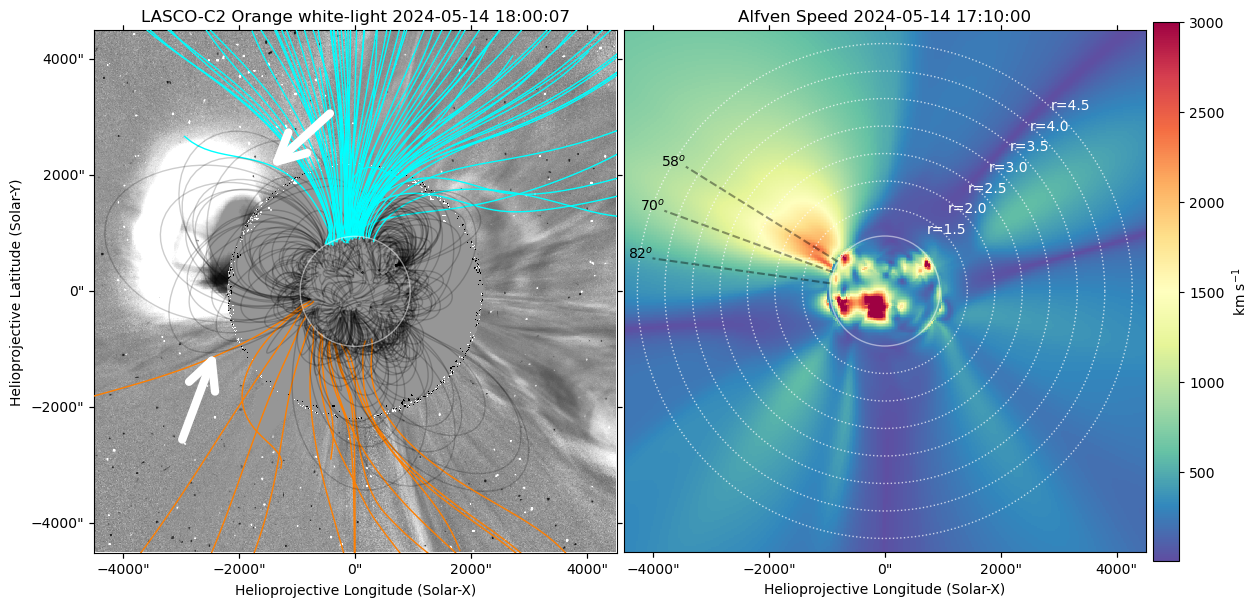

In [123]:
fig = plt.figure(figsize=[14,7], constrained_layout=True)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.02)  # Extra space for the colorbar

# First panel (without colorbar)
ax1 = fig.add_subplot(gs[0], projection=cropped_c2map)
im1 = cropped_c2map.plot(axes=ax1)
cropped_c2map.draw_limb(alpha=0.5)
ax1.grid(False)

# Define start and end points in arcseconds
start = SkyCoord(-3000 * u.arcsec, -2600 * u.arcsec, frame=cropped_c2map.coordinate_frame)
end = SkyCoord(-2400 * u.arcsec, -1000 * u.arcsec, frame=cropped_c2map.coordinate_frame)

# Convert SkyCoord to pixel coordinates
start_px = cropped_c2map.world_to_pixel(start)
end_px = cropped_c2map.world_to_pixel(end)

# Add an arrow using pixel coordinates
ax1.annotate('', xy=(end_px.x.value, end_px.y.value), xytext=(start_px.x.value, start_px.y.value),
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='->', color='w', lw=6, mutation_scale=50))

# Define start and end points in arcseconds
start = SkyCoord(-400 * u.arcsec, 3100 * u.arcsec, frame=cropped_c2map.coordinate_frame)
end = SkyCoord(-1500 * u.arcsec, 2100 * u.arcsec, frame=cropped_c2map.coordinate_frame)

# Convert SkyCoord to pixel coordinates
start_px = cropped_c2map.world_to_pixel(start)
end_px = cropped_c2map.world_to_pixel(end)

# Add an arrow using pixel coordinates
ax1.annotate('', xy=(end_px.x.value, end_px.y.value), xytext=(start_px.x.value, start_px.y.value),
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='->', color='w', lw=6, mutation_scale=50))

if pfss:
    with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
        for fline in flines:
            color = {0:'black', -1:'cyan', 1:'#ff7f00'}.get(fline.polarity)
            if fline.polarity==0:
                opacity = 0.2
            else:
                opacity = 1
            ax1.plot_coord(fline.coords, alpha=opacity, color=color, linewidth=1)
            pbar.update(1)

ax1.set_xlim(left=0, right=int(cropped_c2map.dimensions.x.value))
ax1.set_ylim(bottom=0, top=int(cropped_c2map.dimensions.y.value))


# Second panel (with colorbar)
ax2 = fig.add_subplot(gs[1], projection=cropped_map)
im2 = cropped_map.plot(axes=ax2,
              vmin=1e1, vmax=3e3,
              cmap='Spectral_r')
cropped_map.draw_limb(alpha=0.5)
ax2.set_title('Alfven Speed' + cropped_map.latex_name)
ax2.set_ylabel(' ')
ax2.grid(False)
ax2.coords[1].set_ticks_visible(False)
ax2.coords[1].set_ticklabel_visible(False)

# Draw circles with different radii
for r in np.arange(start=1.5, stop=5, step=0.5):
    draw_circle(ax2, cropped_map, radius_factor=r, color='w', linestyle='dotted', linewidth=1, alpha=0.7)

for value in chosen_slits:
    # line = myfuncs.plot_line(angle_deg=value, length=4000, map_obj=cropped_map)
    line = plot_line(angle_deg=value, length=3100, map_obj=cropped_map)
    ax2.plot_coord(line, color='black', linestyle='--', alpha=0.4)
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = cropped_map.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=cropped_map.coordinate_frame))

    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax2.text(end_point_pixel.x.value - 8, end_point_pixel.y.value + 4, f'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')

# Colorbar (using the third gridspec column)
cax = fig.add_subplot(gs[2])
plt.colorbar(im2, cax=cax, label=r'km s$^{-1}$')

# Force both axes to have the same aspect ratio
ax1.set_aspect(1)
ax2.set_aspect(1)

# Add spacing between the two panels
fig.subplots_adjust(wspace=0.1)  # Increase this value to add more space
# fig.savefig(f'{data_dir}/lascoC2_pfss_forward_valfven.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Add equatorial cut

In [73]:
from psipy.model import MASOutput
import sunpy.coordinates.ephemeris as eph
import astropy.units as u
import numpy as np
from sunpy.coordinates import get_horizons_coord
from astropy.time import Time
import matplotlib.patheffects as path_effects  # For the white outline


mydatetime       = '2024-05-14T17:10'
year, month, day = mydatetime.split('T')[0].split('-')
hour, minute     = mydatetime.split('T')[1].split(':')

# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))

mas_path = f'{data_dir}/PSI_MAS/{year}{month}{day}_{hour}{minute}/'
model = MASOutput(mas_path)

time = Time(f'{year}-{month}-{day} {hour}:{minute}')
earth_coords = get_horizons_coord('399', time)

carr_lon = earth_coords.lon.to(u.deg).value # Get Earth's Carrington longitude
theta = np.deg2rad(carr_lon) # Convert longitude to radians for polar plot

# Define arrow start and end points
r_start = 2.5
r_end   = 4

# Define the angle in degrees and convert to radians
angle_deg = -72
angle_rad = np.radians(angle_deg)
# Define the radius range
rLine_start = 1
rLine_end = 5
# Plot the dotted line from the Active Region, where the CME was launhed
rLine     = np.array([rLine_start, rLine_end]) # Define the radius range
thetaLine = np.array([angle_rad, angle_rad])   # Constant angle for the line
# Add the text next to the line
text_radius = (rLine_start + rLine_end) / 2    # Midpoint of the radius range

# Plot the MAS equatorial slice
# cbar_kwargs = {
#     'orientation': 'horizontal',
#     # 'pad': 0.02,
#     'shrink': 0.7
# }

2025-04-01 19:19:07 - sunpy - INFO: Obtained JPL HORIZONS location for Earth (399)                    


INFO: Obtained JPL HORIZONS location for Earth (399)                     [sunpy.coordinates.ephemeris]


2025-04-01 19:35:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Plotting the field lines: 100%|███████████████████████████████████████████████| 600/600 [00:48<00:00, 12.46it/s]


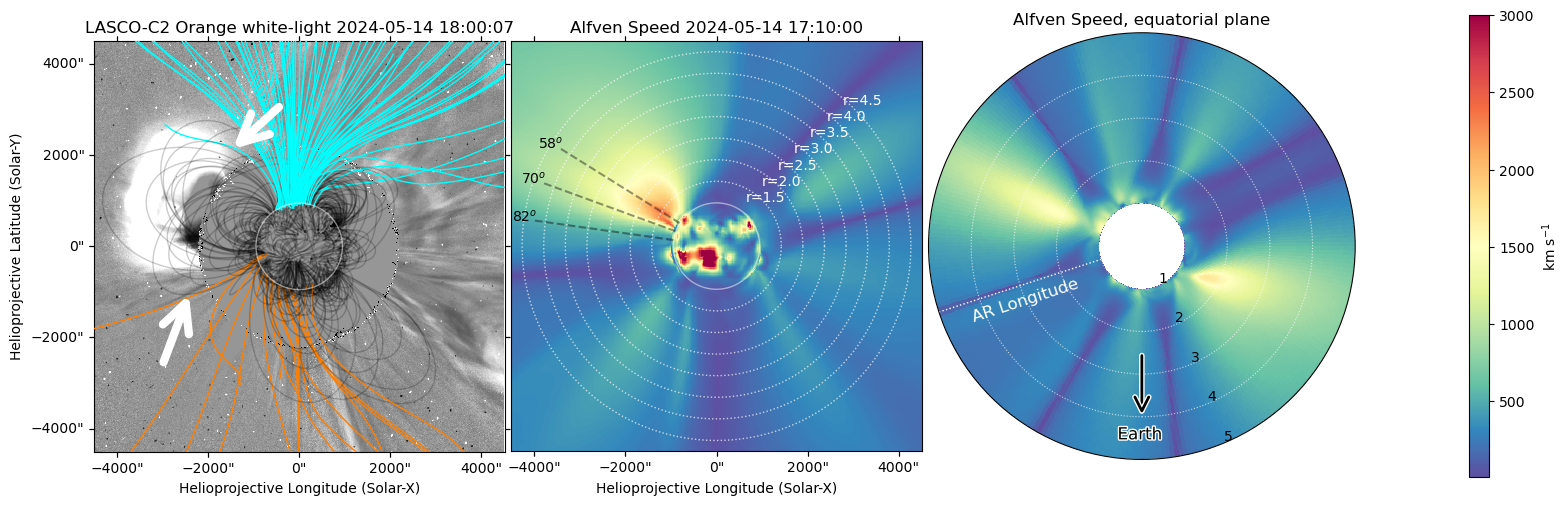

In [99]:
pfss = True


fig = plt.figure(figsize=[18,6], constrained_layout=True)
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1.3, 0.05], wspace=0.02)  # Added space for third panel

# First panel (without colorbar)
ax1 = fig.add_subplot(gs[0], projection=cropped_c2map)
im1 = cropped_c2map.plot(axes=ax1)
cropped_c2map.draw_limb(alpha=0.5)
ax1.grid(False)

# Define start and end points in arcseconds
start = SkyCoord(-3000 * u.arcsec, -2600 * u.arcsec, frame=cropped_c2map.coordinate_frame)
end = SkyCoord(-2400 * u.arcsec, -1000 * u.arcsec, frame=cropped_c2map.coordinate_frame)

# Convert SkyCoord to pixel coordinates
start_px = cropped_c2map.world_to_pixel(start)
end_px = cropped_c2map.world_to_pixel(end)

# Add an arrow using pixel coordinates
ax1.annotate('', xy=(end_px.x.value, end_px.y.value), xytext=(start_px.x.value, start_px.y.value),
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='->', color='w', lw=6, mutation_scale=50))

# Define start and end points in arcseconds
start = SkyCoord(-400 * u.arcsec, 3100 * u.arcsec, frame=cropped_c2map.coordinate_frame)
end = SkyCoord(-1500 * u.arcsec, 2100 * u.arcsec, frame=cropped_c2map.coordinate_frame)

# Convert SkyCoord to pixel coordinates
start_px = cropped_c2map.world_to_pixel(start)
end_px = cropped_c2map.world_to_pixel(end)

# Add an arrow using pixel coordinates
ax1.annotate('', xy=(end_px.x.value, end_px.y.value), xytext=(start_px.x.value, start_px.y.value),
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='->', color='w', lw=6, mutation_scale=50))

if pfss:
    with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
        for fline in flines:
            color = {0:'black', -1:'cyan', 1:'#ff7f00'}.get(fline.polarity)
            if fline.polarity==0:
                opacity = 0.2
            else:
                opacity = 1
            ax1.plot_coord(fline.coords, alpha=opacity, color=color, linewidth=1)
            pbar.update(1)

ax1.set_xlim(left=0, right=int(cropped_c2map.dimensions.x.value))
ax1.set_ylim(bottom=0, top=int(cropped_c2map.dimensions.y.value))


# Second panel (with colorbar)
ax2 = fig.add_subplot(gs[1], projection=cropped_map)
im2 = cropped_map.plot(axes=ax2,
              vmin=10, vmax=3000,
              cmap='Spectral_r')
cropped_map.draw_limb(alpha=0.5)
ax2.set_title('Alfven Speed' + cropped_map.latex_name)
ax2.set_ylabel(' ')
ax2.grid(False)
ax2.coords[1].set_ticks_visible(False)
ax2.coords[1].set_ticklabel_visible(False)

# Draw circles with different radii
for r in np.arange(start=1.5, stop=5, step=0.5):
    draw_circle(ax2, cropped_map, radius_factor=r, color='w', linestyle='dotted', linewidth=1, alpha=0.7)

for value in chosen_slits:
    # line = myfuncs.plot_line(angle_deg=value, length=4000, map_obj=cropped_map)
    line = plot_line(angle_deg=value, length=3100, map_obj=cropped_map)
    ax2.plot_coord(line, color='black', linestyle='--', alpha=0.4)
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = cropped_map.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=cropped_map.coordinate_frame))

    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax2.text(end_point_pixel.x.value - 8, end_point_pixel.y.value + 4, f'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')


# Third panel
ax3 = fig.add_subplot(gs[2], projection='polar')
polar_map = model['va'].plot_equatorial_cut(ax=ax3,
                                # cbar_kwargs=cbar_kwargs,
                                vmin=10, vmax=3000, cmap='Spectral_r')
# Plot the arrow
arrow = ax3.annotate('', 
            xy=(theta, r_end), xytext=(theta, r_start),
            arrowprops=dict(arrowstyle='->', color='k', lw=2, facecolor='k', edgecolor='w', mutation_scale=25))
arrow.arrow_patch.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground='w'),  # White outline around arrow
    path_effects.Normal()  # Normal arrow on top
])
# Add the text "Earth" next to the arrow
text = ax3.text(theta-0.01, r_end+0.6, 'Earth', color='k', fontsize=12, ha='center', va='bottom')
# Apply the white outline to the text
text.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='w'),  # White outline around text
    path_effects.Normal()  # Normal text on top
])
ax3.plot(thetaLine, rLine, linestyle=':', color='w', lw=1)
ax3.text(angle_rad+np.radians(7), text_radius, 'AR Longitude', color='w', fontsize=12, va='center', ha='center', rotation=angle_deg+90)
ax3.grid(color='w', linestyle=':', alpha=0.7)
ax3.set_ylim(0, 5) # Set the radial limit
ax3.set_theta_offset(-np.pi/2) # Rotate the polar plot by 90 degrees (pi/2 radians)
ax3.set_title('Alfven Speed, equatorial plane')
polar_map.colorbar.remove()


# Colorbar (using the third gridspec column)
cax = fig.add_subplot(gs[3])
plt.colorbar(im2, cax=cax, label=r'km s$^{-1}$')

# Force both axes to have the same aspect ratio
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

# Add spacing between the two panels
fig.subplots_adjust(wspace=0.01)  # Increase this value to add more space
fig.savefig(f'{data_dir}/lascoC2_pfss_forward_valfven_equatorialCut.pdf', format='pdf', bbox_inches='tight')
plt.show()

2025-04-01 19:19:11 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


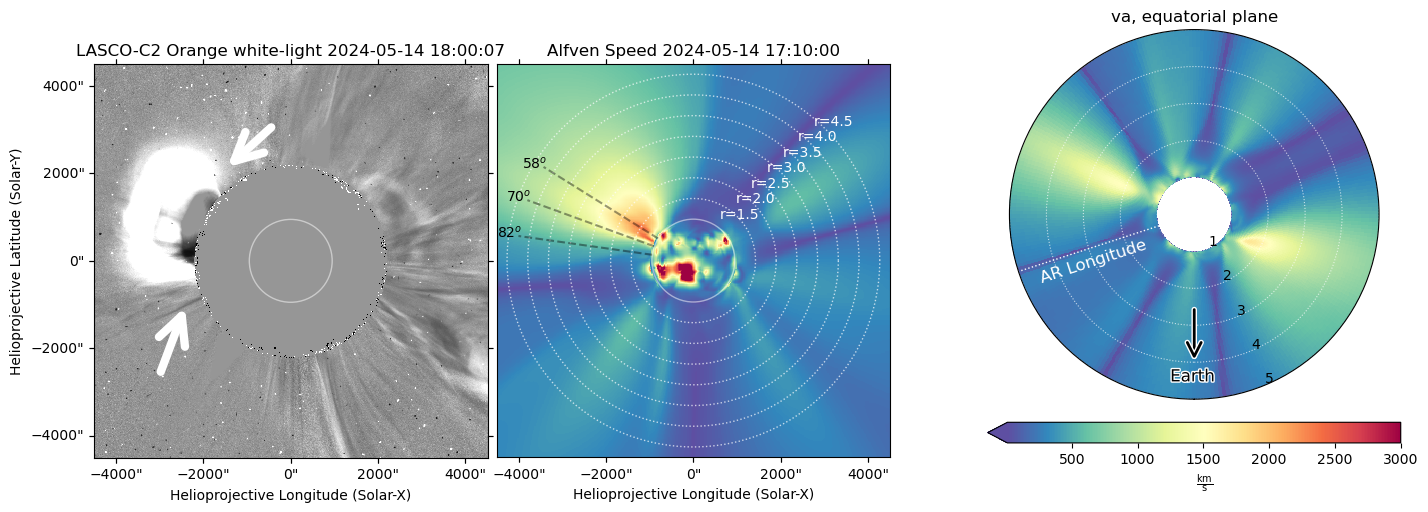

In [74]:
pfss = False


fig = plt.figure(figsize=[18,6], constrained_layout=True)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.5], wspace=0.02)  # Added space for third panel

# First panel (without colorbar)
ax1 = fig.add_subplot(gs[0], projection=cropped_c2map)
im1 = cropped_c2map.plot(axes=ax1)
cropped_c2map.draw_limb(alpha=0.5)
ax1.grid(False)

# Define start and end points in arcseconds
start = SkyCoord(-3000 * u.arcsec, -2600 * u.arcsec, frame=cropped_c2map.coordinate_frame)
end = SkyCoord(-2400 * u.arcsec, -1000 * u.arcsec, frame=cropped_c2map.coordinate_frame)

# Convert SkyCoord to pixel coordinates
start_px = cropped_c2map.world_to_pixel(start)
end_px = cropped_c2map.world_to_pixel(end)

# Add an arrow using pixel coordinates
ax1.annotate('', xy=(end_px.x.value, end_px.y.value), xytext=(start_px.x.value, start_px.y.value),
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='->', color='w', lw=6, mutation_scale=50))

# Define start and end points in arcseconds
start = SkyCoord(-400 * u.arcsec, 3100 * u.arcsec, frame=cropped_c2map.coordinate_frame)
end = SkyCoord(-1500 * u.arcsec, 2100 * u.arcsec, frame=cropped_c2map.coordinate_frame)

# Convert SkyCoord to pixel coordinates
start_px = cropped_c2map.world_to_pixel(start)
end_px = cropped_c2map.world_to_pixel(end)

# Add an arrow using pixel coordinates
ax1.annotate('', xy=(end_px.x.value, end_px.y.value), xytext=(start_px.x.value, start_px.y.value),
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='->', color='w', lw=6, mutation_scale=50))

if pfss:
    with tqdm(total=len(flines), desc='Plotting the field lines') as pbar:
        for fline in flines:
            color = {0:'black', -1:'cyan', 1:'#ff7f00'}.get(fline.polarity)
            if fline.polarity==0:
                opacity = 0.2
            else:
                opacity = 1
            ax1.plot_coord(fline.coords, alpha=opacity, color=color, linewidth=1)
            pbar.update(1)

ax1.set_xlim(left=0, right=int(cropped_c2map.dimensions.x.value))
ax1.set_ylim(bottom=0, top=int(cropped_c2map.dimensions.y.value))


# Second panel (with colorbar)
ax2 = fig.add_subplot(gs[1], projection=cropped_map)
im2 = cropped_map.plot(axes=ax2,
              vmin=10, vmax=3000,
              cmap='Spectral_r')
cropped_map.draw_limb(alpha=0.5)
ax2.set_title('Alfven Speed' + cropped_map.latex_name)
ax2.set_ylabel(' ')
ax2.grid(False)
ax2.coords[1].set_ticks_visible(False)
ax2.coords[1].set_ticklabel_visible(False)

# Draw circles with different radii
for r in np.arange(start=1.5, stop=5, step=0.5):
    draw_circle(ax2, cropped_map, radius_factor=r, color='w', linestyle='dotted', linewidth=1, alpha=0.7)

for value in chosen_slits:
    # line = myfuncs.plot_line(angle_deg=value, length=4000, map_obj=cropped_map)
    line = plot_line(angle_deg=value, length=3100, map_obj=cropped_map)
    ax2.plot_coord(line, color='black', linestyle='--', alpha=0.4)
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = cropped_map.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=cropped_map.coordinate_frame))

    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax2.text(end_point_pixel.x.value - 8, end_point_pixel.y.value + 4, f'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')


# Third panel
ax3 = fig.add_subplot(gs[2], projection='polar')
model['va'].plot_equatorial_cut(ax=ax3,
                                cbar_kwargs=cbar_kwargs,
                                vmin=10, vmax=3000, cmap='Spectral_r')
# Plot the arrow
arrow = ax3.annotate('', 
            xy=(theta, r_end), xytext=(theta, r_start),
            arrowprops=dict(arrowstyle='->', color='k', lw=2, facecolor='k', edgecolor='w', mutation_scale=25))
arrow.arrow_patch.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground='w'),  # White outline around arrow
    path_effects.Normal()  # Normal arrow on top
])
# Add the text "Earth" next to the arrow
text = ax3.text(theta-0.01, r_end+0.6, 'Earth', color='k', fontsize=12, ha='center', va='bottom')
# Apply the white outline to the text
text.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='w'),  # White outline around text
    path_effects.Normal()  # Normal text on top
])
ax3.plot(thetaLine, rLine, linestyle=':', color='w', lw=1)
ax3.text(angle_rad+np.radians(7), text_radius, 'AR Longitude', color='w', fontsize=12, va='center', ha='center', rotation=angle_deg+90)
ax3.grid(color='w', linestyle=':', alpha=0.7)
ax3.set_ylim(0, 5) # Set the radial limit
ax3.set_theta_offset(-np.pi/2) # Rotate the polar plot by 90 degrees (pi/2 radians)

# Force both axes to have the same aspect ratio
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

# Add spacing between the two panels
fig.subplots_adjust(wspace=0.1)  # Increase this value to add more space
# fig.savefig(f'{data_dir}/lascoC2_pfss_forward_valfven_equatorialCut.pdf', format='pdf', bbox_inches='tight')
plt.show()